# **Gramian Angular Summation Field**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import pandas as pd
import tensorflow as tf
import keras, tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

In [20]:
df = pd.read_csv("Data/S27FE-10K.csv")
scaler = StandardScaler() 
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [21]:
def plot_gaf(df: pd.DataFrame, column_name: str) -> None:
    """
    Plots the Gramian Angular Summation and Difference Fields for a specified column in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        column_name (str): The name of the column to transform and plot.
    
    Returns:
        None: Displays the plots.
    """
    # Extract the time series from the DataFrame
    ts = df[column_name].values
    
    # Normalize the time series to the interval [-1, 1]
    ts_min, ts_max = ts.min(), ts.max()
    ts_norm = 2 * (ts - ts_min) / (ts_max - ts_min) - 1
    
    # Reshape to (n_samples, series_length) as required by pyts
    X = np.array([ts_norm])
    
    # Compute Gramian Angular Fields using summation and difference methods
    gasf = GramianAngularField(method='summation')
    gadf = GramianAngularField(method='difference')
    X_gasf = gasf.fit_transform(X)
    X_gadf = gadf.fit_transform(X)
    
    # Plot the results side by side
    plt.figure(figsize=(12, 5))
    
    # Plot the GASF
    plt.subplot(1, 2, 1)
    plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
    plt.title(f'Gramian Angular Summation Field\n({column_name})')
    plt.axis('off')
    
    # Plot the GADF
    plt.subplot(1, 2, 2)
    plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
    plt.title(f'Gramian Angular Difference Field\n({column_name})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

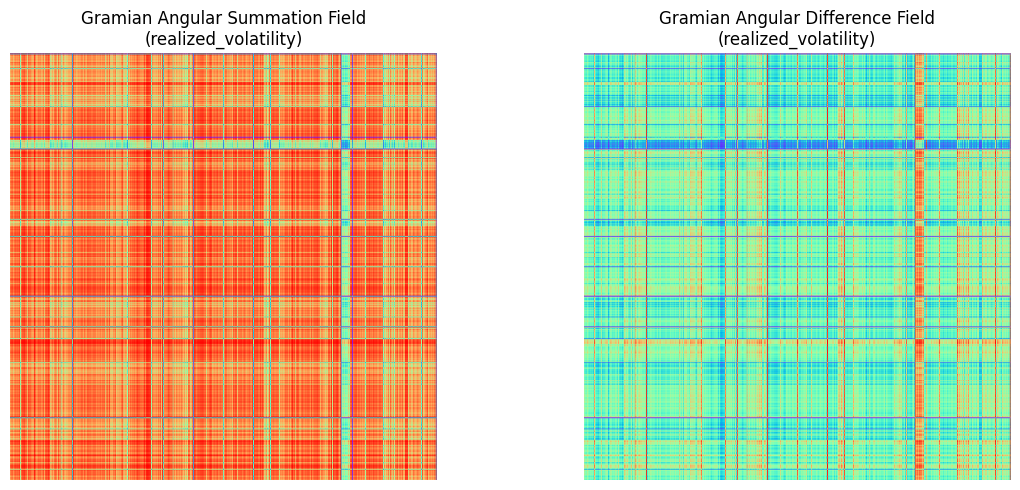

In [22]:
plot_gaf(df, 'realized_volatility')

Epoch 1/100


/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/volt/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7135 - val_loss: 1.2635
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7478 - val_loss: 1.2285
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6999 - val_loss: 1.2421
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6270 - val_loss: 1.1944
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6039 - val_loss: 1.1978
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6541 - val_loss: 1.1984
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6265 - val_loss: 1.1883
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6516 - val_loss: 1.2034
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6050 - val_loss: 1.1665
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6105 - val_loss: 1.1780
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5732 - val_loss: 1.1740
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

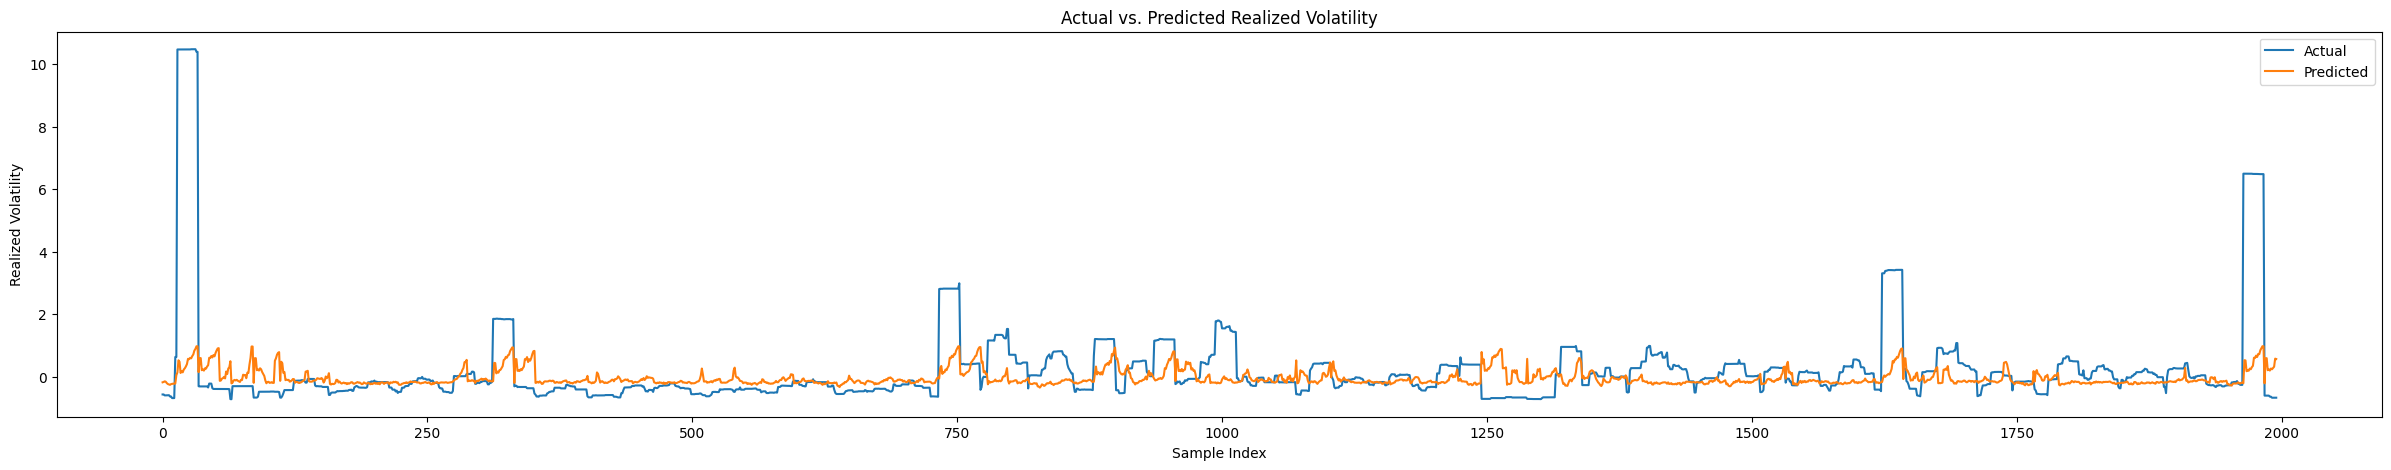

In [31]:
window_size = 20  
horizon = 1       # Predict the volatility at the next time step

# Number of samples available with the given window and horizon
n_samples = len(df) - window_size - horizon + 1

# Initialize lists to store the generated images and corresponding labels
X_images = []
y = []

# Instantiate the Gramian Angular Field transformer (using the summation method)
gasf = GramianAngularField(method='summation')

# Create samples using a sliding window
for i in range(n_samples):
    # Extract a window of the time series
    ts_window = df["realized_volatility"].iloc[i : i + window_size].values
    
    # Normalize the time series window to the interval [-1, 1]
    ts_min, ts_max = ts_window.min(), ts_window.max()
    ts_norm = 2 * (ts_window - ts_min) / (ts_max - ts_min) - 1
    
    # Reshape as required by pyts: (n_samples, series_length)
    ts_norm = ts_norm.reshape(1, -1)
    
    # Convert the normalized time series window into a GAF image
    gaf_image = gasf.fit_transform(ts_norm)  # shape: (1, window_size, window_size)
    X_images.append(gaf_image[0])  # Append the image (2D array)
    
    # Define the label as the future volatility at the prediction horizon
    label = df["realized_volatility"].iloc[i + window_size + horizon - 1]
    y.append(label)

# Convert the lists into numpy arrays
X_images = np.array(X_images)   # Shape: (n_samples, window_size, window_size)
y = np.array(y)                 # Shape: (n_samples,)

# CNNs expect images with a channel dimension, so we add an extra axis
X_images = X_images[..., np.newaxis]  # New shape: (n_samples, window_size, window_size, 1)

# -----------------------------
# Train-Test Split
# -----------------------------
# For time-series forecasting, use the first 80% for training and the remainder for testing.
split_index = int(0.8 * len(X_images))
X_train, X_test = X_images[:split_index], X_images[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# -----------------------------
# Model Building
# -----------------------------
# Define a simple CNN for regression.


# -----------------------------
# Define the Regularized CNN
# -----------------------------
model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', 
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(window_size, window_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),

    Dense(1, activation='linear')  # Regression output
])

# -----------------------------
# Compile the model
# -----------------------------
model.compile(optimizer='adam', loss='mse')

# -----------------------------
# Early stopping
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# -----------------------------
# Train the model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,                # Set high, let early stopping decide
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# Evaluate and plot
# -----------------------------
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {test_loss}')

y_pred = model.predict(X_test)

# Plot actual vs. predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Realized Volatility')
plt.title('Actual vs. Predicted Realized Volatility')
plt.legend()
plt.show()

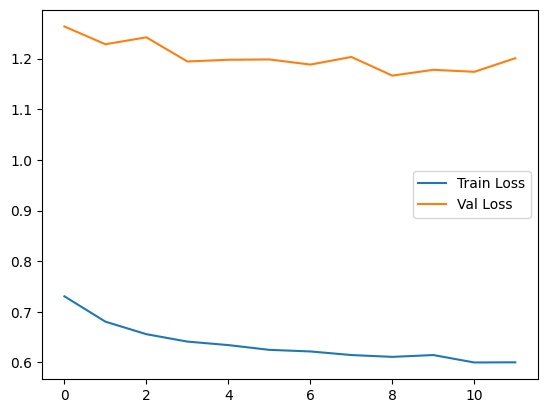

In [32]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()
